In [1]:
# import matplotlib as mpl
# COLOR = 'white'
# mpl.rcParams['text.color'] = COLOR
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR
# mpl.rcParams['ytick.color'] = COLOR

# import fancyimpute as fi
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import variation
from math import isnan

from scipy.cluster.hierarchy import dendrogram,linkage

import sys
sys.path.append("./src/")
import lumberjack
import tree_reader as tr
import tree_braider2 as trbr

In [2]:
# counts = np.loadtxt('/Users/boris/taylor/johnston_retina/single_cell/dmel-retina-scRNA/exploration/2018.07.19_Scanpy/log_counts.txt')
# header = np.loadtxt("/Users/boris/taylor/johnston_retina/single_cell/dmel-retina-scRNA/exploration/2018.07.19_Scanpy/header.txt",dtype=str)

# counts = np.loadtxt('/Users/boris/taylor/aging_sc/var_filtered_counts.txt')
# header = np.loadtxt("/Users/boris/taylor/aging_sc/var_filtered_header.txt",dtype=str)

# counts = np.loadtxt('/Users/boris/taylor/fan_tendon/log_counts.txt')
# header = np.loadtxt("/Users/boris/taylor/fan_tendon/header.txt",dtype=str)

counts = np.loadtxt('/Users/boris/taylor/vision/rust_prototype/raw_data/counts.txt')
header = np.loadtxt('/Users/boris/taylor/vision/rust_prototype/forest_prot/header.txt',dtype=str)
header[header=='error'] = [h+str(i) for i,h in enumerate(header[header=='error'])]

# feature_sort = dendrogram(linkage(counts.T,metric='correlation',method='average'),no_plot=True)['leaves']

# counts = counts[cell_sort].T[feature_sort].T
# counts = counts.T[feature_sort].T
# header = header[feature_sort]

# plt.figure(figsize=(15,10))
# plt.title("Cell x Gene Expression Unsorted",fontsize=20)
# plt.imshow(counts,aspect='auto')
# plt.xlabel("Genes",fontsize=15)
# plt.ylabel("Cells",fontsize=15)
# plt.colorbar()
# plt.show()

# cell_sort = dendrogram(linkage(counts,metric='cos',method='average'),no_plot=True)['leaves']

# plt.figure(figsize=(15,10))
# plt.title("Cell x Gene Expression, Agglomerative",fontsize=20)
# plt.imshow(counts[cell_sort],aspect='auto')
# plt.xlabel("Genes",fontsize=15)
# plt.ylabel("Cells",fontsize=15)
# plt.colorbar()
# plt.show()


print(counts.shape)
print(header.shape)

(1656, 4773)
(4773,)


In [3]:
output_directory = "./prediction/"
raw_text_out = open(output_directory + str("evaluation.txt"),mode='w')



In [4]:

training_mask = np.random.random(counts.shape[0]) > .1
testing_mask = np.logical_not(training_mask)

training_counts = counts[training_mask]
testing_counts = counts[testing_mask]

forest = tr.Forest.reconstitute('./forest_vision')

# forest = lumberjack.fit(training_counts,trees=200,dispersion_mode="ssme",norm="l2",drop='none',sfr=1,in_feature_subsample=200,out_feature_subsample=200,sample_subsample=1000,depth=10,leaves=100,header=header)

# forest.weigh_leaves()

predicted = forest.predict_matrix(testing_counts)

true_counts = testing_counts

subsampling = 1

# mask = np.loadtxt('./testing/holdout_mask_counts.txt')

# held_out_counts = np.loadtxt('./testing/held_out_counts.txt')

In [5]:
# forest.backup('./forest_johnston_ihmm')
# forest.backup('./forest_johnston_ssme')
# forest.backup('./forest_johnston_flat_sme')
# forest.backup('./forest_johnston_var')
# forest.backup('./forest_fan_ssme')
# forest.backup('./forest_vision')

In [6]:
# Optional adjustment to truncate lower-expressing genes.
# expression_level_mask = np.mean(true_counts,axis=0) > 1
# true_counts = true_counts.T[expression_level_mask].T
# predicted = predicted.T[expression_level_mask].T

In [7]:


# raw_text_out.write("=================================================\n")
# raw_text_out.write("Basic evaluation: \n")

# raw_text_out.write("Pearson R\n")
# raw_text_out.write(str(pearsonr(predicted.flatten(),true_counts.flatten())) + "\n")

# raw_text_out.write("MSE\n")
# raw_text_out.write(str(np.mean((predicted.flatten() - true_counts.flatten()) ** 2)) + "\n")

# raw_text_out.write("MAE\n")
# raw_text_out.write(str(np.mean(np.abs(predicted.flatten() - true_counts.flatten()))) + "\n")


# raw_text_out.close()

In [8]:
# sys.path.append("/Users/boris/haxx/python/smooth_density_graph/")
# import smooth_density_graph as sdg

# forest.reset_clusters()
# from scipy.cluster.hierarchy import linkage,dendrogram

# encoding = forest.node_sample_encoding(forest.leaves())

# print(np.sum(np.sum(encoding,axis=1) == 0))
# cell_sort = dendrogram(linkage(encoding,metric='cos',method='average'),no_plot=True)['leaves']
# leaf_sort = dendrogram(linkage(encoding.T,metric='cos',method='average'),no_plot=True)['leaves']

# plt.figure(figsize=(10,10))
# # plt.imshow(encoding,aspect='auto',cmap='binary')
# plt.imshow(encoding[cell_sort].T[leaf_sort].T,aspect='auto',cmap='binary')
# plt.show()


# print(np.sum(np.isnan(encoding).flatten()))

# cell_clusterings = forest.cluster_samples_encoding(subsample=1000,distance='cos',k=10,steps=10,override=True,verbose=True)
# leaf_clusterings = forest.cluster_leaf_samples(subsample=2200,distance='cos',k=10,steps=10,override=False,verbose=True)

# cell_order = np.argsort(cell_clusterings)
# leaf_order = np.argsort(leaf_clusterings)

# clustered_counts = forest.counts[cell_order]
# # clustered_counts = encoding[cell_order].T[leaf_sort].T

# plt.figure(figsize=(15,10))
# plt.title("Cell x Gene Expression, Forest Clustering",fontsize=20)
# plt.imshow(clustered_counts,aspect='auto')
# plt.xlabel("Genes",fontsize=15)
# plt.ylabel("Cells",fontsize=15)
# plt.colorbar()
# plt.show()


# print("===================")

# for cluster in forest.sample_clusters:
#     print(len(cluster.samples))

# print("===================")

# for cluster in forest.leaf_clusters:
#     print(len(cluster.nodes))

# print("===================")
# print("===================")
# print("===================")
# print(len(forest.sample_clusters))
# print(len(forest.leaf_clusters))

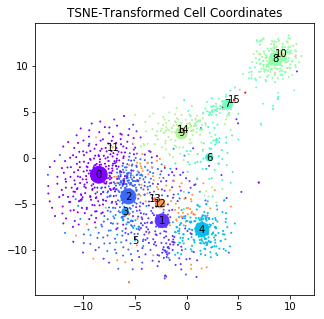

In [9]:
# forest.leaf_clusters[0].ranked_mean_gains()
# forest.leaf_clusters[0].prerequisite_frequency()
# forest.leaf_clusters[3].biological_cluster_summary()
# print(forest.weighted_node_vector_prediction(forest.leaf_clusters[0].nodes))
# print(forest.weighted_node_vector_prediction([forest.prototype.root]))
forest.plot_cell_clusters()
# forest.plot_cell_clusters(colorize=False)

In [10]:
# from sklearn.manifold import TSNE
# forest.trees[0].root.child_clusters
# nodes,labels,encoding = forest.cluster_divergence(subsample=2300,k=10,distance='manhattan',verbose=True,steps=10,auto=True)
# print(len(forest.divergence_clusters[4].nodes[2].samples))

# encoding_ordering = np.argsort(labels)

# plt.figure(figsize=(10,10))
# plt.imshow(encoding,aspect='auto')
# plt.show()

# plt.figure(figsize=(10,10))
# plt.imshow(encoding[encoding_ordering],aspect='auto')
# plt.show()

# tc = TSNE().fit_transform(forest.counts)
# tc = forest.tsne(no_plot=True)

# forest.leaf_clusters[3].plot_cell_counts(cmap='magma')


# for leaf_cluster in forest.leaf_clusters:
#     print(leaf_cluster.id)
#     leaf_cluster.plot_cell_counts()
    
# forest.divergence_clusters[x].plot_cell_counts()
# print([len(dc.nodes) for dc in forest.divergence_clusters])
# print([n.level for n in forest.divergence_clusters[x].nodes])
# print([n.feature for n in forest.divergence_clusters[x].nodes])
# plt.figure(figsize=(10,10))
# plt.hist([n.feature for n in forest.divergence_clusters[x].nodes])
# plt.xticks(rotation='vertical')
# plt.show()

In [11]:
# ss_i = forest.truth_dictionary.feature_dictionary['ss']
# o_i = forest.truth_dictionary.feature_dictionary['Optix']
# oc_i = forest.truth_dictionary.feature_dictionary['oc']
# scrt_i = forest.truth_dictionary.feature_dictionary['scrt']
# skip_i = forest.truth_dictionary.feature_dictionary['SKIP']
# gasp_i = forest.truth_dictionary.feature_dictionary['Gasp']
# rox1l_i = forest.truth_dictionary.feature_dictionary['lncRNA:roX1']
# rox2l_i = forest.truth_dictionary.feature_dictionary['lncRNA:roX2']
# # sxl_i = forest.truth_dictionary.feature_dictionary['Sxl']
# serp_i = forest.truth_dictionary.feature_dictionary['Spn43Aa']
# appl_i = forest.truth_dictionary.feature_dictionary['Appl']
# nrm_i = forest.truth_dictionary.feature_dictionary['nrm']
# gl_i = forest.truth_dictionary.feature_dictionary['gl']
# tyn_i = forest.truth_dictionary.feature_dictionary['tyn']
# aop_i = forest.truth_dictionary.feature_dictionary['aop']
# hth_i = forest.truth_dictionary.feature_dictionary['hth']
# nw_i = forest.truth_dictionary.feature_dictionary['nw']
# espl_i = forest.truth_dictionary.feature_dictionary['E(spl)m8-HLH']
# ance_i = forest.truth_dictionary.feature_dictionary['Ance']
# mmp2_i = forest.truth_dictionary.feature_dictionary['Mmp2']
# rbp6_i = forest.truth_dictionary.feature_dictionary['Rbp6']
# nrv3_i = forest.truth_dictionary.feature_dictionary['nrv3']

# cell_labels = forest.sample_labels

# plt.figure(figsize=(12,10))
# plt.title("Simple Cell Clusters")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=cell_labels,cmap='rainbow')
# plt.show()

# plt.figure(figsize=(10,10))
# plt.title("oc",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,oc_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Optix",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,o_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Spineless",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,ss_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("scrt",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,scrt_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("SKIP",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,skip_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Gasp",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,gasp_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Rox1Lnc",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,rox1l_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Rox2Lnc",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,rox2l_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Spn43Aa",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,serp_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Appl",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,appl_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("nrm",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,nrm_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("gl",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,gl_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("tyn",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,tyn_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("aop",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,aop_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("hth",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,hth_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("nw",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,nw_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("E(spl)m8-HLH",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,espl_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Ance",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,ance_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Mmp2",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,mmp2_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Rbp6",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,rbp6_i],cmap='magma')
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,10))
# plt.title("Nrv3",fontsize="30")
# plt.scatter(tc[:,0],tc[:,1],s=3,c=forest.counts[:,nrv3_i],cmap='magma')
# plt.colorbar()
# plt.show()

In [12]:
# forest.leaf_clusters[8].biological_cluster_summary()
# forest.leaf_clusters[7].average_prereq_freq_level()
# forest.leaf_clusters[11].average_prereq_freq_level()
# # forest.leaf_clusters[11].biological_cluster_summary()
# # forest.leaf_clusters[18].biological_cluster_summary()
# # print(forest.leaf_clusters[7].ranked_feature_error_gain()[0][-20:])
# # print(forest.leaf_clusters[11].ranked_feature_error_gain()[0][-20:])
# # print(forest.leaf_clusters[18].ranked_feature_error_gain()[0][-20:])

# cl0_cells = forest.sample_clusters[0].samples
# cl5_cells = forest.sample_clusters[5].samples
# cl3_cells = forest.sample_clusters[3].samples
# cl9_cells = forest.sample_clusters[9].samples
# cl7_cells = forest.sample_clusters[7].samples

# plt.figure()
# plt.title("E(spl)m8-HLH across all cells",fontsize=25)
# plt.hist(forest.counts[:,espl_i],bins=np.arange(0,5,.25))
# plt.show()

# plt.figure()
# plt.title("E(spl)m8-HLH in Cluster 0",fontsize=25)
# plt.hist(forest.counts[cl0_cells][:,espl_i],bins=np.arange(0,5,.25))
# plt.show()

# plt.figure()
# plt.title("E(spl)m8-HLH in Cluster 3",fontsize=25)
# plt.hist(forest.counts[cl3_cells][:,espl_i],bins=np.arange(0,5,.25))
# plt.show()

# plt.figure()
# plt.title("E(spl)m8-HLH in Cluster 5",fontsize=25)
# plt.hist(forest.counts[cl5_cells][:,espl_i],bins=np.arange(0,5,.25))
# plt.show()

# plt.figure()
# plt.title("E(spl)m8-HLH in Cluster 7",fontsize=25)
# plt.hist(forest.counts[cl7_cells][:,espl_i],bins=np.arange(0,5,.25))
# plt.show()

# plt.figure()
# plt.title("E(spl)m8-HLH in Cluster 9",fontsize=25)
# plt.hist(forest.counts[cl9_cells][:,espl_i],bins=np.arange(0,5,.25))
# plt.show()


# plt.figure()
# plt.title("Nw across all cells",fontsize=25)
# plt.hist(forest.counts[:,nw_i],bins=np.arange(0,5,.25))
# plt.show()

# plt.figure()
# plt.title("Nw in Cluster 0",fontsize=25)
# plt.hist(forest.counts[cl0_cells][:,nw_i],bins=np.arange(0,5,.25))
# plt.show()

# plt.figure()
# plt.title("Nw in Cluster 3",fontsize=25)
# plt.hist(forest.counts[cl3_cells][:,nw_i],bins=np.arange(0,5,.25))
# plt.show()

# plt.figure()
# plt.title("Nw in Cluster 5",fontsize=25)
# plt.hist(forest.counts[cl5_cells][:,nw_i],bins=np.arange(0,5,.25))
# plt.show()

# plt.figure()
# plt.title("Nw in Cluster 7",fontsize=25)
# plt.hist(forest.counts[cl7_cells][:,nw_i],bins=np.arange(0,5,.25))
# plt.show()

# plt.figure()
# plt.title("Nw in Cluster 9",fontsize=25)
# plt.hist(forest.counts[cl9_cells][:,nw_i],bins=np.arange(0,5,.25))
# plt.show()


In [13]:
# import random
# print(forest.trees[0].root.child_clusters)
# print([l.cluster for l in forest.trees[0].root.leaves()])
# forest.leaves()[0].cluster
# forest.leaves()[0].find_cluster_divergence(1889).child_clusters


# distance_mtx = np.zeros((len(forest.leaf_clusters),len(forest.leaf_clusters)))

# for i,c1 in enumerate(forest.leaf_clusters):
#     for j,c2 in enumerate(forest.leaf_clusters):
        
#         _nodes,distances = forest.find_leaf_cluster_divergence(c1.id,c2.id)
        
#         md = np.mean(distances)
#         if np.isnan(md):
#             md = 5 + random.random()
#         distance_mtx[i,j] = md

# plt.figure(figsize=(10,10))
# cluster_sort = dendrogram(linkage(distance_mtx,metric='cos',method='average'),no_plot=False)['leaves']
# plt.show()

# plt.figure(figsize=(10,10))
# plt.imshow(distance_mtx[cluster_sort].T[cluster_sort].T,aspect='auto')
# plt.colorbar()
# plt.show()



In [14]:
# cluster_matrix = np.zeros((len(forest.sample_clusters),len(forest.leaf_clusters)))
# for i,sample_cluster in enumerate(forest.sample_clusters):
#     leaf_cluster_frequency = sample_cluster.leaf_cluster_frequency(plot=False)[1]
#     for j,lcf in enumerate(leaf_cluster_frequency):
#         cluster_matrix[i,j] = lcf
        
# plt.figure(figsize=(20,10))
# plt.title("Occurrence of Leaf Clusters in Cell Clusters",fontsize=30)
# plt.imshow(np.log(cluster_matrix+1),aspect='auto')
# plt.xlabel("Leaf Clusters",fontsize=24)
# plt.ylabel("Cell Clusters",fontsize=24)
# plt.colorbar()
# plt.show()

# vertical_order = dendrogram(linkage(cluster_matrix,metric='correlation'),no_plot=True)['leaves']
# horizontal_order = dendrogram(linkage(cluster_matrix.T,metric='correlation'),no_plot=True)['leaves']

# rearranged_sample_ticks = np.arange(len(forest.sample_clusters))[vertical_order]
# rearranged_leaf_ticks = np.arange(len(forest.leaf_clusters))[horizontal_order]

# plt.figure(figsize=(20,10))
# plt.title("Occurrence of Leaf Clusters in Cell Clusters",fontsize=30)
# plt.imshow(np.log(cluster_matrix+1)[vertical_order].T[horizontal_order].T,aspect='auto')
# plt.xlabel("Leaf Clusters",fontsize=24)
# plt.ylabel("Cell Clusters",fontsize=24)
# plt.xticks(np.arange(len(rearranged_leaf_ticks)),rearranged_leaf_ticks)
# plt.yticks(np.arange(len(rearranged_sample_ticks)),rearranged_sample_ticks)
# plt.colorbar()
# plt.show()

In [15]:
# forest.prereq_summary()

In [16]:
# plt.figure()
# dendrogram(linkage(forest.sample_cluster_coordinate_matrix()),labels=[cluster.id for cluster in forest.sample_clusters])
# plt.show()

In [17]:
# forest.sample_clusters[4].leaf_cluster_frequency()

In [18]:
# forest.leaf_clusters[3].biological_cluster_summary()

In [19]:
# forest.leaf_clusters[0].average_prereq_freq_level()
# forest.leaf_clusters[1].average_prereq_freq_level()
# forest.leaf_clusters[6].average_prereq_freq_level()


In [20]:
# # from sklearn.cluster import DBSCAN
# from hdbscan import HDBSCAN

# encoding = forest.node_sample_encoding(forest.leaves())

# d_cell_clusters = HDBSCAN(min_samples=5).fit_predict(encoding)
# d_leaf_clusters = HDBSCAN(min_samples=5).fit_predict(encoding.T)

# d_cell_ordering = np.argsort(d_cell_clusters)
# # leaf_ordering = np.argsort(d_leaf_clusters)
# d_leaf_ordering = dendrogram(linkage(encoding.T,metric='cos',method='average'),no_plot=True)['leaves']


# plt.figure(figsize=(20,8))
# plt.imshow(encoding[d_cell_ordering].T[d_leaf_ordering].T,aspect='auto',cmap='binary')
# plt.show()

# plt.figure(figsize=(20,8))
# plt.imshow(training_counts[d_cell_ordering],aspect='auto')
# plt.show()

# print(set(d_cell_clusters))

In [21]:
# d_p_cell_clusters = HDBSCAN(min_samples=5).fit_predict(training_counts)
# d_p_feature_clusters = HDBSCAN(min_samples=5).fit_predict(training_counts.T)

# d_p_cell_ordering = np.argsort(d_p_cell_clusters)
# # d_p_feature_ordering = np.argsort(d_p_feature_clusters)

# plt.figure(figsize=(20,8))
# plt.imshow(training_counts[d_p_cell_ordering],aspect='auto',cmap='binary')
# plt.show()

# print(set(d_p_cell_clusters))

In [22]:
# from sklearn.manifold import TSNE

# # t_coordinates = TSNE().fit_transform(forest.node_sample_encoding(forest.leaves()))
# t_coordinates = TSNE().fit_transform(forest.counts)

# plt.figure(figsize=(15,10))
# plt.title("Cells Transformed by TSNE (Arbitrary Units)",fontsize=20)
# plt.scatter(t_coordinates[:,0],t_coordinates[:,1],s=.1)
# plt.show()

# # for cluster in set(cell_clusters):
# #     print(np.sum(np.array(cell_clusters) == cluster))

In [23]:
# sys.path.append("/Users/boris/haxx/python/smooth_density_graph/")
# import smooth_density_graph as sdg

# # encoding = forest.node_sample_encoding(forest.leaves())

# sdg_encoding_cell_clusters = sdg.fit_predict(encoding,"fitpredict",subsample=1800,k=5,steps=10,verbose=True)

# sdg_encoding_cell_ordering = np.argsort(sdg_cell_clusters)

# # sdg_leaf_clusters = sdg.fit_predict(encoding.T,"fitpredict",subsample=2300,k=5,steps=10,verbose=True)

# # sdg_leaf_ordering = np.argsort(sdg_leaf_clusters)

# sdg_count_cell_clusters = sdg.fit_predict(forest.counts,"fitpredict",subsample=1800,k=5,steps=10,verbose=True)

# sdg_count_cell_ordering = np.argsort(sdg_count_cell_clusters)

# sdg_feature_clusters = sdg.fit_predict(forest.counts.T,"fitpredict",subsample=750,k=5,steps=10,verbose=True)

# sdg_feature_ordering = np.argsort(sdg_feature_clusters)

# tc = forest.tsne(no_plot=True)
# density = sdg.fit_predict(forest.node_sample_encoding(forest.leaves()),command="density",subsample=2000,k=5,steps=5,verbose=True)

# plt.figure(figsize=(15,10))
# plt.scatter(tc[:,0],tc[:,1],c=np.log(density),s=20,alpha=.7,cmap='viridis')
# plt.scatter(tc[:,0],tc[:,1],c=density,s=30,alpha=.7,cmap='magma')
# plt.colorbar()
# plt.show()

# plt.figure(figsize=(15,10))
# plt.title("Cell x Gene Expression, Smooth Gradient Graph",fontsize=20)
# plt.imshow(forest.counts[sdg_encoding_cell_ordering].T[sdg_feature_ordering].T,aspect='auto')
# plt.xlabel("Genes",fontsize=15)
# plt.ylabel("Cells",fontsize=15)
# # plt.colorbar()
# plt.show()

# plt.figure(figsize=(15,10))
# plt.title("Cell x Gene Expression, Smooth Gradient Graph",fontsize=20)
# plt.imshow(forest.counts[sdg_count_cell_ordering].T[sdg_feature_ordering].T,aspect='auto')
# plt.xlabel("Genes",fontsize=15)
# plt.ylabel("Cells",fontsize=15)
# # plt.colorbar()
# plt.show()




In [24]:
# from sklearn.cluster import KMeans

# k_cell_clusters = KMeans(n_clusters=10).fit_predict(counts)

# k_cell_ordering = np.argsort(k_cell_clusters)

# plt.figure(figsize=(15,10))
# plt.title("Cell x Gene Expression, K-Means",fontsize=20)
# plt.imshow(counts[k_cell_ordering],aspect='auto')
# plt.xlabel("Genes",fontsize=15)
# plt.ylabel("Cells",fontsize=15)
# plt.colorbar()
# plt.show()

In [25]:
# import gravity_clustering as grc

# encoding = forest.node_sample_encoding(forest.leaves())

# g_cell_clusters = grc.fit_predict(encoding,'mobile',sample_sub=500,smoothing=3,step_fraction=.5,steps=1000,borrow=1,verbose=True)
# g_leaf_clusters = grc.fit_predict(encoding.T,'mobile',sample_sub=500,smoothing=3,step_fraction=.5,steps=1000,borrow=1,verbose=True)

# g_cell_ordering = np.argsort(g_cell_clusters)
# g_leaf_ordering = np.argsort(g_leaf_clusters)

# plt.figure()
# plt.imshow(encoding[g_cell_ordering].T[g_leaf_ordering].T,aspect='auto',cmap='binary')
# plt.show()

In [26]:
# forest.node_sample_encoding(forest.leaves())
# forest.leaves()[3].samples
# forest.trees[3].plot()
# forest.trees[3].tree_movie('./tree_movies/m1/pr1')
# forest.trees[4].tree_movie('./tree_movies/m2/pr1')

In [27]:
# zero_mask = counts == 0
# zero_sum = np.sum(zero_mask,axis=0)
# zero_percentrage = zero_sum / counts.shape[0]

# plt.figure("sparsity_graph",figsize=(15,10))
# plt.title("Sparsity of Features in Fly Retina Dataset",fontsize=20)
# plt.hist(zero_percentrage,bins=np.arange(0,1.05,0.05))
# plt.xlabel("Sparsity (Fraction of values = 0)",fontsize=15)
# plt.ylabel("Frequency",fontsize=15)
# plt.show()

In [28]:
# random_mask = np.random.rand(*true_counts.flatten().shape) < (subsampling/10)

# plt.figure("general_scatter")
# plt.title("True Expression vs Predicted Expression")
# plt.scatter(true_counts.flatten()[random_mask],predicted.flatten()[random_mask],s=.1,alpha=.3)
# plt.xlabel("True Expression")
# plt.ylabel("Predicted Expression")
# plt.savefig(output_directory+"general_scatter.png")

In [29]:

# plt.figure("mae_vs_mean",figsize=(20,4))
# plt.title("Mean Absolute Error of Feature Predictions vs Mean Feature Value")
# plt.scatter(np.mean(true_counts,axis=0),np.mean(np.abs(true_counts - predicted), axis=0),s=.1)
# plt.plot([0,4],[0,4],c='r')
# plt.xlabel("Mean Gene Expression")
# plt.ylabel("Mean Absolute Error")
# plt.ylim((0,4))
# plt.savefig(output_directory+"mae_vs_mean.png")

# # Calculate MAE
# mae = np.mean(np.abs(true_counts - np.tile(np.mean(true_counts,axis=0),(true_counts.shape[0],1))), axis=0)

# plt.figure("mean_abs_dev_vs_mean",figsize=(20,4))
# plt.title("Mean Absolute Deviation of Features vs Expression Level")
# plt.scatter(np.mean(true_counts,axis=0),mae,s=.1)
# plt.plot([0,4],[0,4],c='r')
# plt.xlabel("Mean Gene Expression")
# plt.ylabel("Mean Absolute Deviation")
# plt.ylim((0,4))
# plt.savefig(output_directory+"mean_abs_dev_vs_mean.png")

In [30]:
# random_mask = np.random.rand(*true_counts.flatten().shape) < subsampling

# plt.figure("bimodal_scatter_by_mean",figsize=(6,4))
# plt.title("Observed Expressions Vs Mean Expression of Feature")
# plt.scatter(np.tile(np.mean(true_counts,axis=0),(true_counts.shape[0],1)).flatten()[random_mask],true_counts.flatten()[random_mask],s=.1,alpha=.1, label="Observed Expression")
# # plt.scatter(np.mean(true_counts,axis=0),np.median(true_counts,axis=0),c='r',s=.5, label="Mean Expression")
# plt.xlabel("Mean Expression")
# plt.ylabel("Observed Expression")
# plt.xlim(0,4)
# plt.legend()
# plt.savefig(output_directory+"bimodal_scatter_by_mean.png")

# for cluster in forest.sample_clusters:
#     cluster_samples = cluster.samples
#     cluster_counts = forest.counts[cluster_samples]
#     mean_expression = np.mean(cluster_counts,axis=0)
#     print(cluster_counts.shape)
#     plt.figure()
#     plt.scatter(np.tile(mean_expression,(cluster_counts.shape[0],1)).flatten(),cluster_counts.flatten(),s=.1,alpha=.1)
#     plt.xlim(0,4)
#     plt.show()

In [31]:
# # print true_counts[:10,:10]

# random_mask = np.random.rand(*true_counts.flatten().shape) < subsampling

# plt.figure("bimodal_scatter_by_mean_predicted",figsize=(20,4))
# plt.title("Predicted Values Vs Observed Means")
# plt.scatter(np.tile(np.mean(true_counts,axis=0),(true_counts.shape[0],1)).flatten()[random_mask],predicted.flatten()[random_mask],s=.1,alpha=.1,label="Expression")
# plt.scatter(np.mean(true_counts,axis=0),np.median(true_counts,axis=0),c='m',s=.5,label="Medians")
# plt.scatter(np.mean(true_counts,axis=0),np.mean(true_counts,axis=0),c='c',s=.5,label="Means")
# plt.xlim(0,3)
# plt.legend()
# plt.savefig(output_directory+"bimodal_scatter_by_mean_predicted.png")


In [32]:
# random_mask = np.random.rand(*true_counts.flatten().shape) < subsampling

# plt.figure("error_scatter_by_mean", figsize=(20,4))
# plt.title("Observed Error vs Observed Mean of Feature")
# plt.scatter(np.tile(np.mean(true_counts,axis=0),(true_counts.shape[0],1)).flatten()[random_mask],(true_counts - predicted).flatten()[random_mask],alpha=.1,s=.1)
# plt.xlabel("Mean Expression")
# plt.ylabel("Predicted Expression")
# plt.savefig(output_directory+"error_scatter_by_mean.png")

In [33]:
# plt.figure("mean_error_vs_mean",figsize=(20,4))
# plt.title("Mean Absolute Error Vs Mean Expression of Gene")
# plt.scatter(np.mean(true_counts,axis=0),np.mean(np.abs(true_counts-predicted),axis=0),s=.1,c=np.std(true_counts,axis=0))
# plt.colorbar(label="Standard Deviation of Feature")
# # plt.plot([0,3],[0,3])
# plt.ylim((0,4))
# plt.xlabel("Mean Expression")
# plt.ylabel("Mean Error")
# plt.savefig(output_directory+"mean_error_vs_mean.png")

In [34]:
# plt.figure("mean_error_vs_std",figsize=(4,4))
# plt.title("Mean Absolute Error Vs Standard Deviation of Gene Expression")
# plt.scatter(np.std(true_counts,axis=0),np.mean(np.abs(true_counts-predicted),axis=0),s=.1)
# # plt.colorbar(label="Standard Deviation of Feature")
# plt.plot([0,4],[0,4])
# plt.ylim((0,4))
# plt.xlim((0,4))
# plt.xlabel("Standard Deviation")
# plt.ylabel("Mean Error")
# plt.savefig(output_directory+"mean_error_vs_std.png")

In [35]:
# # true_counts = np.loadtxt('../raw_data/counts.txt')
# # predicted = np.loadtxt('./predictions/combined_mixed')

# correlations = []

# for i in range(true_counts.shape[1]):
    
#     correlations.append(pearsonr(true_counts[:,i],predicted[:,i])[0])
#     if isnan(correlations[-1]):
#         correlations[-1] = 0
        

# print(len(correlations))

# plt.figure("correlation_vs_mean",figsize=(20,4))
# plt.title("Correlation of Predictions to Features per Feature")
# plt.scatter(np.mean(true_counts,axis=0),correlations,s=.1,c=np.std(true_counts,axis=0))
# plt.colorbar(label="Standard Deviation of Feature")
# plt.xlabel("Mean Expression")
# plt.ylabel("Prediction Correlation")
# plt.savefig(output_directory+"correlation_vs_mean.png")

In [36]:
# from scipy.stats import linregress

# x = np.std(true_counts,axis=0)
# y = np.mean(true_counts-predicted,axis=0)

# slope, intercept, rvalue, pvalue, std_err = linregress(x, y=y)

# plt.figure("mean_error_vs_variance")
# plt.title("Standard Deviation vs Mean Error")
# plt.scatter(x,y,s=.1)
# # plt.plot(x,x*slope + intercept, 'r', label = str(np.around(rvalue,decimals=3)))
# plt.plot([0,3],[0,3])
# plt.plot([0,3],[0,-3])
# plt.ylim((-1,1))
# plt.xlabel("Standard Deviation")
# plt.ylabel("Mean Error")
# plt.legend()
# plt.savefig(output_directory+"mean_error_vs_variance.png")

In [37]:
# # predicted = np.loadtxt('./predictions/combined_prediction')
# correlations = []

# for i in range(true_counts.shape[1]):
#     correlations.append(pearsonr(true_counts[:,i],predicted[:,i])[0])
#     if isnan(correlations[-1]):
#         correlations[-1] = 0
# print(len(correlations))

    
# plt.figure("correlation_vs_mean",figsize=(20,4))
# plt.title("Correlation of Predictions vs Expression Level")
# plt.scatter(correlations,np.mean(true_counts,axis=0),s=.3,c=variation(true_counts,axis=0))
# plt.ylabel("Mean Expression")
# plt.xlabel("Correlation")
# plt.colorbar(label="Coefficient of Variation")
# plt.clim(0,10)
# plt.savefig(output_directory+"correlation_vs_mean_vs_cov.png",dpi=500)

In [38]:
# correlations = []

# for i in range(true_counts.shape[1]):
#     correlations.append(pearsonr(true_counts[:,i],predicted[:,i])[0])
#     if isnan(correlations[-1]):
#         correlations[-1] = 0
    
# print(len(correlations))

# plt.figure("correlation_vs_cov")
# plt.title("Correlation of features vs Coefficient of Variance")
# plt.xlabel("Coefficient of Variation")
# plt.ylabel("Correlation")
# plt.scatter(variation(true_counts,axis=0),correlations,s=.1,c=np.std(true_counts,axis=0))
# plt.colorbar(label="Standard Deviation of Feature")
# plt.xlim(0,2)
# plt.show()

In [39]:
# random_mask = np.random.rand(*true_counts.flatten().shape) < (subsampling/10.0)

# errors = true_counts - predicted

# plt.figure("error_vs_true_expression")
# plt.title("Error vs True Expression")
# plt.scatter(true_counts.flatten()[random_mask],errors.flatten()[random_mask],s=.1,alpha=.3,c=np.tile(np.mean(true_counts,axis=0),(true_counts.shape[0],1)).flatten()[random_mask],cmap='inferno')
# plt.xlabel("True Expression")
# plt.ylabel("Error")
# plt.colorbar(label="Mean expression of gene")
# plt.savefig(output_directory+"error_vs_true_expression.png")

In [40]:
# error = predicted - true_counts 

# mean_cell_error = np.mean(error,axis=1)
# mean_gene_error = np.mean(error,axis=0)

# print(mean_gene_error.shape)
# print(mean_cell_error.shape)

# plt.figure()
# plt.title("Distribution of Mean Feature Errors")
# plt.hist(mean_gene_error,bins=20)
# plt.xlabel("Mean Error")
# plt.ylabel("Frequency")
# plt.show()

# plt.figure()
# plt.title("Distribution of Mean Cell Errors")
# plt.hist(mean_cell_error,bins=20)
# plt.xlabel("Mean Error")
# plt.ylabel("Frequency")
# plt.show()


In [41]:
# expression_sorted_features = true_counts.T[np.argsort(np.mean(true_counts,axis=0))].T
# expression_sorted_prediction = predicted.T[np.argsort(np.mean(true_counts,axis=0))].T


# plt.figure("predictability")
# plt.title("Correlation of Features to Other Features, Sorted By Mean Expression")
# plt.imshow(np.corrcoef(expression_sorted_features.T))
# plt.colorbar(label="Correlation")
# plt.show()


In [42]:
# expression_sorted_features = forest.counts.T[np.argsort(np.mean(forest.counts,axis=0))].T

# random_mask = np.random.rand(*expression_sorted_features.flatten().shape) < subsampling

# plt.figure("ranked_feature_expression",figsize=(20,4))
# plt.title("Observed Expressions For Each Feature Ranked By Mean Expression")
# plt.scatter(np.tile(np.arange(expression_sorted_features.shape[1]),(expression_sorted_features.shape[0],1)).flatten()[random_mask],expression_sorted_features.flatten()[random_mask],s=.1,alpha=.1, label="Observed Expression")
# # plt.scatter(np.mean(true_counts,axis=0),np.median(true_counts,axis=0),c='r',s=.5, label="Mean Expression")
# plt.xlabel("Feature Rank")
# plt.ylabel("Observed Expression")
# plt.ylim((0,10))
# plt.legend()
# plt.savefig(output_directory+"rank_ordered_expresssion.png")

# for cluster in forest.sample_clusters:
#     cluster_samples = cluster.samples
#     cluster_counts = expression_sorted_features[cluster_samples]
#     print(cluster_counts.shape)
#     plt.figure(figsize=(20,4))
#     plt.scatter(np.tile(np.arange(cluster_counts.shape[1]),(cluster_counts.shape[0],1)).flatten(),cluster_counts.flatten(),s=.5,alpha=.5)
#     plt.show()

In [43]:
# def quick_hetorskedasticity(feature):
#     sorted_feature = sorted(feature)
#     first = sorted_feature[:int(len(sorted_feature)/2)]
#     second = sorted_feature[int(len(sorted_feature)/2):]
#     fv = np.var(first)
#     sv = np.var(second)
#     return fv,sv

# expression_sorted_features.shape

# # random_mask = np.random.rand(*expression_sorted_features.flatten().shape) < subsampling

# heteroskedasticity = [quick_hetorskedasticity(feature)[0]/quick_hetorskedasticity(feature)[1] for feature in expression_sorted_features.T]
# var1 = [quick_hetorskedasticity(feature)[0] for feature in expression_sorted_features.T]
# var2 = [quick_hetorskedasticity(feature)[1] for feature in expression_sorted_features.T]

# print(var1)
# print(var2)

# # print(len(heteroskedasticity))

# # print(heteroskedasticity)

# plt.figure("heteroskedasticity",figsize=(20,4))
# plt.title("Heteroskedasticity",fontsize=20)
# plt.scatter(np.arange(0,len(var1)),var1,s=4,alpha=1,c='r',label="First")
# plt.scatter(np.arange(0,len(var2)),var2,s=4,alpha=1,c='b',label="Second")
# # plt.scatter(np.mean(true_counts,axis=0),np.median(true_counts,axis=0),c='r',s=.5, label="Mean Expression")
# plt.xlabel("Feature Rank",fontsize=15)
# plt.ylabel("Ratio\n Var for f greater than median vs less",fontsize=12)
# plt.legend()
# plt.savefig(output_directory+"heterskedasticity.png")

# plt.figure("heteroskedasticity2",figsize=(20,4))
# plt.title("Heteroskedasticity",fontsize=20)
# plt.scatter(np.arange(0,len(heteroskedasticity)),heteroskedasticity,s=4,alpha=1,c='b')
# plt.xlabel("Feature Rank",fontsize=15)
# plt.ylabel("Ratio\n Var for f greater than median vs less",fontsize=12)
# plt.savefig(output_directory+"heterskedasticity.png")

In [44]:
# import random

# for j in range(10):
#     i = random.randint(1,true_counts.shape[0])
#     plt.figure('cell_multiplex' + str(i))
#     plt.scatter(np.arange(expression_sorted_features.shape[1]),expression_sorted_features[i],s=.1)
#     plt.show()

In [45]:
# for j in range(10):
#     i = random.randint(1,expression_sorted_features.shape[1])
#     plt.figure("feature_dist_multiplex" + str(i))
#     plt.hist(expression_sorted_features[:,i],bins=50,log=True)
#     plt.show()

# # deciles = np.zeros((20,expression_sorted_features.shape[1]))
# # derivatives = np.zeros((19,expression_sorted_features.shape[1]))
# # for i,feature in enumerate(expression_sorted_features.T):
# #     bins,edges = np.histogram(feature,bins=20,range=(np.min(feature),np.max(feature)))
# # #     print(bins)
# # #     print(edges)
# # #     print(np.array([y-x for x,y in zip(bins,bins[1:])]))
# #     deciles[:,i] = bins
# #     derivatives[:,i] = np.array([y-x for x,y in zip(bins,bins[1:])])

# # plt.figure(figsize=(20,4))
# # plt.imshow(deciles,aspect='auto')
# # plt.show()

# # plt.figure(figsize=(20,4))
# # plt.imshow(derivatives,aspect='auto')
# # plt.show()

In [46]:
# # print true_counts[:10,:10]

# # expression_sorted_features = true_counts.T[np.argsort(np.mean(true_counts,axis=0))].T

# # expression_sorted_prediction = predicted.T[np.argsort(np.mean(true_counts,axis=0))].T

# # random_mask = np.random.rand(*expression_sorted_features.flatten().shape) < (subsampling)

# plt.figure("ranked_feature_predicted",figsize=(20,4))
# plt.title("Predicted Values By Mean Expression Ranking")
# plt.scatter(np.tile(np.arange(expression_sorted_features.shape[1]),(expression_sorted_features.shape[0],1)).flatten()[random_mask],expression_sorted_prediction.flatten()[random_mask],s=.05,alpha=.3,label="Expression",c=np.abs(expression_sorted_prediction-expression_sorted_features).flatten()[random_mask],cmap='plasma')
# # plt.scatter(np.arange(expression_sorted_features.shape[1]),np.median(expression_sorted_features,axis=0),c='m',s=.5,label="Medians")
# # plt.scatter(np.arange(expression_sorted_features.shape[1]),np.mean(expression_sorted_features,axis=0),c='c',s=.5,label="Means")
# plt.legend()
# plt.colorbar(label="Absolute Value of Error")
# plt.clim(0,10)
# plt.savefig(output_directory+"rank_ordered_predicted.png",dpi=500)

In [47]:
# random_mask = np.random.rand(*expression_sorted_features.flatten().shape) < subsampling

# plt.figure("error_scatter_ranked", figsize=(20,4))
# plt.title("Observed Error By Mean Expression Ranking")
# plt.scatter(np.tile(np.arange(expression_sorted_features.shape[1]),(expression_sorted_features.shape[0],1)).flatten()[random_mask],(expression_sorted_features - expression_sorted_prediction).flatten()[random_mask],alpha=.1,s=.1)
# plt.xlabel("Rank")
# plt.ylabel("Predicted Expression")
# plt.savefig(output_directory+"rank_ordered_error.png")

In [48]:
# correlations = []

# for i in range(true_counts.shape[1]):
    
#     correlations.append(pearsonr(true_counts[:,i],predicted[:,i])[0])
#     if isnan(correlations[-1]):
#         correlations[-1] = 0
        
# plt.figure("correlation_vs_mean",figsize=(20,4))
# plt.title("Correlation of Predictions per Expression Ranked Feature")
# plt.scatter(np.arange(len(correlations)),np.array(correlations)[np.argsort(np.mean(true_counts,axis=0))],s=.1)
# plt.xlabel("Feature Mean Expression Rank")
# plt.ylabel("Prediction Correlation")
# plt.savefig(output_directory+"ranked_correlation.png")

In [49]:
# import random
 
# j = 0

# while j < 10:
#     i = random.randint(1,expression_sorted_features.shape[1])
#     if pearsonr(expression_sorted_features[:,i],expression_sorted_prediction[:,i])[0] < .5:
#         continue
#     plt.figure('feature_pred_multiplex' + str(i))
#     plt.gca().axis('equal')
#     plt.title("Mean Expresion: " + str(np.mean(expression_sorted_features[:,i])) + " Corr: " + str(pearsonr(expression_sorted_features[:,i],expression_sorted_prediction[:,i])[0]))
#     plt.scatter(expression_sorted_features[:,i],expression_sorted_prediction[:,i],s=1)
#     plt.xlabel("True Expression")
#     plt.ylabel("Predicted Expression")
#     plt.show()
    
#     j += 1

In [50]:
# correlations = []

# for i in range(expression_sorted_features.shape[1]):
    
#     correlations.append(pearsonr(expression_sorted_features[:,i],expression_sorted_prediction[:,i])[0])
#     if isnan(correlations[-1]):
#         correlations[-1] = 0
    
# print(len(correlations))
# print(correlations[:10])
# print(np.arange(.05,1,.05))
    
# plt.figure("correlation_histogram")
# plt.title("Distribution of Feature Correlations")
# plt.hist(correlations,bins=np.arange(0,1,.05))
# plt.savefig(output_directory+"correlation_distributions.png")

In [51]:
# pearsonr(true_counts.flatten(),imputed_gradient.flatten())

In [52]:
# plt.figure()
# plt.title("Median Random Forest Prediction")
# plt.xlabel("Truth")
# plt.ylabel("Imputed")
# plt.scatter(truth,pred_basic_forest,s=.003)
# plt.plot([0,15],[0,15])
# plt.savefig('figures/basic_error_scatter.png')

In [53]:
# print np.var(predicted,axis=0).shape

# plt.figure("means")
# plt.title("Distribution of Means")
# plt.hist(np.mean(true_counts,axis=0),bins=np.arange(20),alpha=.1,label="Data")
# plt.show()

# plt.figure("stds")
# plt.title("Distribution of Standard Deviations")
# plt.hist(np.std(true_counts,axis=0), bins=np.arange(20),alpha=.1,label="Data")
# plt.show()

# plt.figure("naive_mae")
# plt.title("Distribution of Means of Error")
# plt.hist(np.mean(np.abs(true_counts - predicted), axis=0),bins=np.arange(20),alpha=.1,label="Error")
# plt.show()

# plt.figure("naive_mse")
# plt.title("Distribution of MSE per feature")
# plt.hist(np.mean((true_counts - predicted)**2, axis=0),bins=np.arange(20),alpha=.1,label="Error")
# plt.show()

# np.random.shuffle(predicted)
# plt.figure("mae_shuffled")
# plt.title("Distribution of Means of Error (Shuffled)")
# plt.hist(np.var(np.abs(true_counts - predicted),axis=0),bins=np.arange(20),alpha=.1,label="Shuffled")
# # plt.legend()
# plt.show()


In [54]:
# plt.figure()
# plt.title("Gradient Random Forest Prediction")
# plt.xlabel("Truth")
# plt.ylabel("Imputed")
# plt.scatter(truth,pred_gradient,s=.003)
# plt.plot([0,15],[0,15])
# plt.savefig('figures/gradient_error_scatter.png')

In [55]:
# print np.sum(true_counts,axis=1).shape

# plt.figure("cell_histograms")
# plt.title("Frequency of Total Cell Counts")
# plt.hist(np.sum(true_counts,axis=1))

# plt.show()

In [56]:
# power = 2

# print(np.sum(true_counts,axis=1).shape)

# plt.figure("cell_histograms")
# plt.title("Frequency of Total Cell Counts (Log)")
# plt.hist(np.sum(np.power(true_counts,power),axis=1))
# plt.show()

In [57]:
# plt.figure()
# plt.title("KNN Imputation")
# plt.xlabel("Truth")
# plt.ylabel("Imputed")
# plt.scatter(truth,pred_knn,s=.003)
# plt.plot([0,15],[0,15])
# plt.savefig('figures/knn_error_scatter.png')

In [58]:
# plt.figure()
# plt.title("Soft Imputation Prediction")
# plt.xlabel("Truth")
# plt.ylabel("Imputed")
# plt.scatter(truth,pred_soft,s=.003)
# plt.plot([0,15],[0,15])
# plt.savefig('figures/soft_error_scatter.png')

In [59]:
# plt.figure()
# plt.title("Sklearn Random Forest Prediction")
# plt.xlabel("Truth")
# plt.ylabel("Imputed")
# plt.scatter(truth,pred_builtin,s=.003)
# plt.plot([0,15],[0,15])
# plt.savefig('figures/sklearn_rf_error_scatter.png')

In [60]:
# true_iris = np.loadtxt('./testing/iris.trunc')
# dropped_iris = np.loadtxt('./testing/iris.drop')
# nan_iris = dropped_iris.copy()
# nan_iris[nan_iris == 0] = np.nan

# forest_prediction = np.loadtxt('./iris_test/run.prediction')

In [61]:
# soft_iris = fi.SoftImpute().complete(nan_iris)

# knn_iris = fi.KNN(k=15).complete(nan_iris)

# factorized_iris = fi.MatrixFactorization().complete(nan_iris)

# iterative_iris = fi.IterativeSVD(rank=5).complete(nan_iris)

In [62]:

# guess_mask = dropped_iris.flatten() == 0

# truth = true_iris.flatten()[guess_mask] 

# print "Pearson correlations of Soft, KNN, Factorized, and Forest"
# print pearsonr(soft_iris.flatten()[guess_mask],truth)
# print pearsonr(knn_iris.flatten()[guess_mask],truth)
# print pearsonr(factorized_iris.flatten()[guess_mask],truth)
# print pearsonr(forest_prediction.flatten()[guess_mask],truth)

# print "MSE of Soft, KNN, Factorized, and Forest"
# print np.mean(((soft_iris.flatten()[guess_mask] - truth) ** 2))
# print np.mean(((knn_iris.flatten()[guess_mask] - truth) ** 2))
# print np.mean(((factorized_iris.flatten()[guess_mask] - truth) ** 2))
# print np.mean(((forest_prediction.flatten()[guess_mask] - truth) ** 2))


In [63]:
# plt.figure("soft_iris")
# plt.title("Soft Imptuation of the Iris Dataset")
# plt.xlabel("Imputed")
# plt.ylabel("True")
# plt.scatter(soft_iris.flatten()[guess_mask],true_iris.flatten()[guess_mask],s=1)
# plt.plot([0,8],[0,8])
# plt.tight_layout()
# plt.savefig("figures/soft_iris_scatter.png")

# plt.figure("knn_iris")
# plt.title("KNN Imptuation of the Iris Dataset")
# plt.xlabel("Imputed")
# plt.ylabel("True")
# plt.scatter(knn_iris.flatten()[guess_mask],true_iris.flatten()[guess_mask],s=1)
# plt.plot([0,8],[0,8])
# plt.tight_layout()
# plt.savefig("figures/knn_iris_scatter.png")

# plt.figure("factorized_iris")
# plt.title("Matrix Factorization Imptuation of the Iris Dataset")
# plt.xlabel("Imputed")
# plt.ylabel("True")
# plt.scatter(factorized_iris.flatten()[guess_mask],true_iris.flatten()[guess_mask],s=1)
# plt.plot([0,8],[0,8])
# plt.tight_layout()
# plt.savefig("figures/factorized_iris_scatter.png")

# plt.figure("forest_iris")
# plt.title("Median Forest (Non-Gradient) Imptuation of the Iris Dataset")
# plt.xlabel("Imputed")
# plt.ylabel("True")
# plt.scatter(forest_prediction.flatten()[guess_mask],true_iris.flatten()[guess_mask],s=1)
# plt.plot([0,8],[0,8])
# plt.tight_layout()
# plt.savefig("figures/forest_iris_scatter.png")

In [64]:
# nan_counts = held_out_counts.copy()
# nan_counts[nan_counts == 0] = np.nan

# soft_blood = fi.SoftImpute().complete(nan_counts)

# knn_blood = fi.KNN(k=15).complete(nan_counts)

In [65]:
# mask = mask.astype(dtype=bool)
# # mask = np.logical_and(true_counts != 0, mask)

# truth = true_counts[mask].flatten()
# pred_basic_forest = imputed_basic[mask].flatten()
# pred_gradient = imputed_gradient[mask].flatten()

# pred_builtin = imputed_builtin[mask].flatten()

# pred_knn = knn_blood[mask].flatten()
# pred_soft = soft_blood[mask].flatten()

# print "Pearson of random, gradient, builtin, knn, and soft"

# print pearsonr(truth,pred_basic_forest)
# print pearsonr(truth,pred_gradient)
# print pearsonr(truth,pred_builtin)
# print pearsonr(truth,pred_knn)
# print pearsonr(truth,pred_soft)

# print "MSE of random, gradient, builtin, knn, and soft"

# print np.mean((pred_basic_forest - truth) ** 2)
# print np.mean((pred_gradient - truth) ** 2)
# print np.mean((pred_builtin - truth) ** 2)
# print np.mean((pred_knn - truth) ** 2)
# print np.mean((pred_soft - truth) ** 2)

# print "Mean absolute error"
# print np.mean(np.abs(pred_basic_forest - truth))
# print np.mean(np.abs(pred_gradient - truth))
# print np.mean(np.abs(pred_builtin - truth))
# print np.mean(np.abs(pred_knn - truth))
# print np.mean(np.abs(pred_soft - truth))


In [66]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import train_test_split
# from scipy.stats import pearsonr

# import time

# start_time = time.time()

# for i in range(10):

#     print "Selecting features"
    
#     in_features = np.random.rand(true_counts.shape[1]) > .7
#     out_features = np.logical_not(in_features)

#     training_samples = np.random.rand(true_counts.shape[0]) > .3
#     testing_samples = np.logical_not(training_samples)

#     training_in = true_counts[training_samples].T[in_features].T
#     training_out = true_counts[training_samples].T[out_features].T

#     testing_in = true_counts[testing_samples].T[in_features].T
#     testing_out = true_counts[testing_samples].T[out_features].T

#     print "Initializing feature"
    
#     forest = GradientBoostingRegressor()

#     print "Fitting"
    
#     forest.fit(training_in,training_out)
    
#     print "Predicting"
    
#     prediction = forest.predict(testing_in)

#     print np.sum(in_features)
#     print np.sum(out_features)
#     print np.sum(training_samples)
#     print np.sum(testing_samples)
    
#     print prediction.shape
#     print testing_out.shape
    
#     print "Pearson R"
#     print pearsonr(testing_out.flatten(),prediction.flatten())
    
#     print "MSE"
#     print np.mean((prediction.flatten() - testing_out.flatten()) ** 2)
    
#     print "MAE"
#     print np.mean(np.abs(prediction.flatten() - testing_out.flatten()))

    
# print "Fitting done"

# end_time = time.time()

# print start_time - end_time

In [67]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from scipy.stats import pearsonr

# import time

# start_time = time.time()

# for i in range(10):

#     print "Selecting features"
    
#     in_features = np.random.rand(true_counts.shape[1]) > .7
#     out_features = np.logical_not(in_features)

#     training_samples = np.random.rand(true_counts.shape[0]) > .3
#     testing_samples = np.logical_not(training_samples)

#     training_in = true_counts[training_samples].T[in_features].T
#     training_out = true_counts[training_samples].T[out_features].T

#     testing_in = true_counts[testing_samples].T[in_features].T
#     testing_out = true_counts[testing_samples].T[out_features].T

#     print "Initializing feature"
    
#     forest = RandomForestRegressor(n_estimators=100,min_samples_split=50,n_jobs=int(10),max_features=400)

#     print "Fitting"
    
#     forest.fit(training_in,training_out)
    
#     print "Predicting"
    
#     prediction = forest.predict(testing_in)

#     print np.sum(in_features)
#     print np.sum(out_features)
#     print np.sum(training_samples)
#     print np.sum(testing_samples)
    
#     print prediction.shape
#     print testing_out.shape
    
#     print "Pearson R"
#     print pearsonr(testing_out.flatten(),prediction.flatten())
    
#     print "MSE"
#     print np.mean((prediction.flatten() - testing_out.flatten()) ** 2)
    
#     print "MAE"
#     print np.mean(np.abs(prediction.flatten() - testing_out.flatten()))

    
# print "Fitting done"http://localhost:8888/notebooks/evaluate_prediction.ipynb#

# end_time = time.time()

# print start_time - end_time

In [68]:
braid = trbr.IHMM.reconstitute('./forest_vision_braid')
# braid = trbr.IHMM(forest,alpha=1,beta=30,gamma=10,start_states=100,alpha_e=.5,beta_e=.5)

In [69]:
# for i in range(300):
#     print("********")
#     print(i)
#     print(braid.alpha)
#     print(braid.beta)
#     print(braid.gamma)
#     print(len(braid.hidden_states))
#     print("********")
#     braid.sample_states()

In [70]:
# for i in range(2000):
#     print("********")
#     print(f"SWEEP:{i}")
#     braid.sweep()
#     print(braid.beta)
#     print(braid.gamma)
#     print(braid.oracle_transition_counts)
#     print(braid.transition_counts)
#     print("********")


In [71]:
# for i in range(100):
#     braid.sweep()
#     if i%5 == 0:
#         braid.max_likelihood_sweep()
# list(braid.state_sample_log_odds[1])
# np.sum(np.abs(braid.state_sample_log_odds[1]))

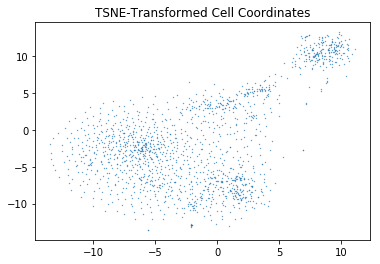

In [72]:
iftc = forest.tsne()

# cell_id_header = np.loadtxt('/Users/boris/taylor/vision/python_prototype/raw_data/vision_sc/cell_id_header.txt',dtype='str')
# cell_ids = np.loadtxt('/Users/boris/taylor/vision/python_prototype/raw_data/vision_sc/cell_identity.txt',dtype=bool)

# mep_index = list(cell_id_header).index('MEP_narrow')

# print(mep_index)
# print(np.sum(cell_ids[:,mep_index]))

# plt.figure()
# plt.scatter(iftc[:,0],iftc[:,1],c=cell_ids[:,mep_index])
# plt.show()

/Users/boris/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


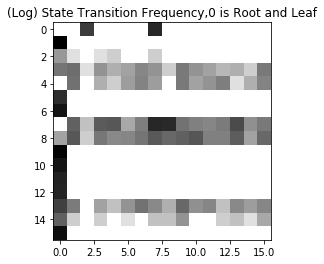

[ 0.43063435 -1.5849625  -0.30485458 ...  0.73696559 -1.04730571
 -0.14438991]
3191


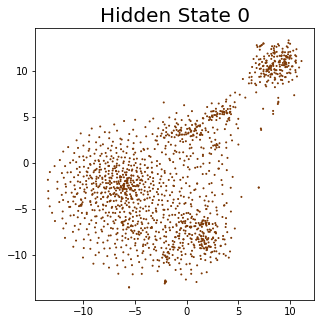

279


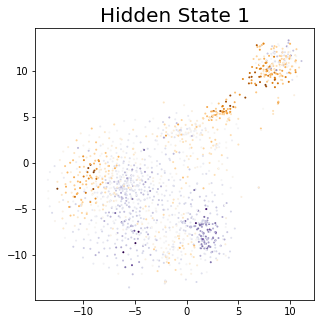

22


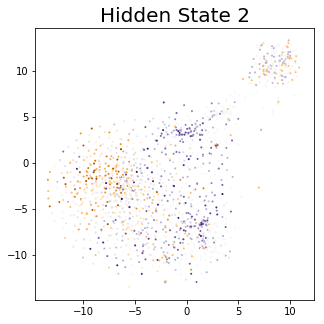

164


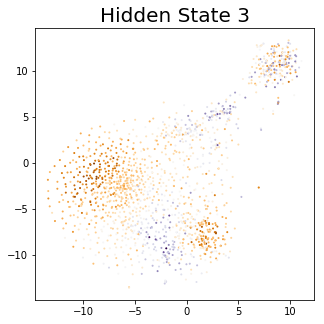

172


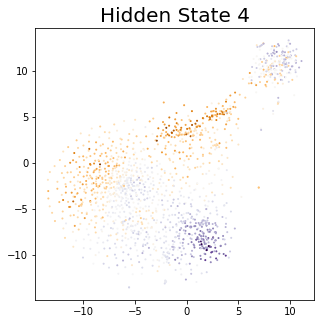

117


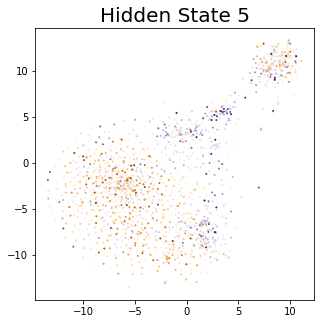

172


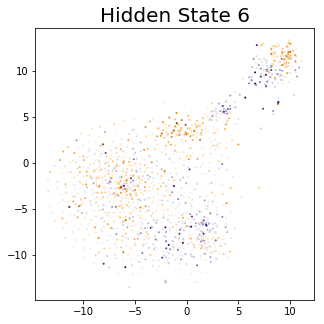

507


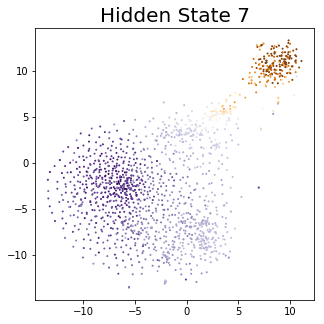

362


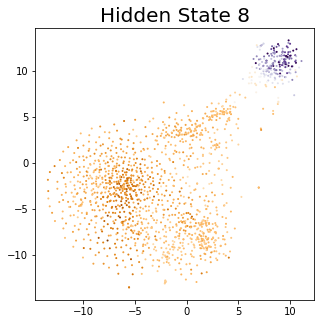

243


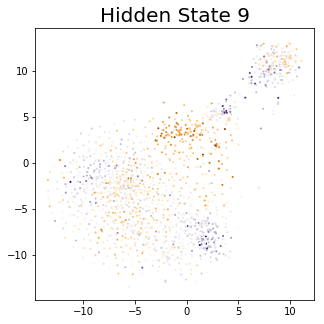

170


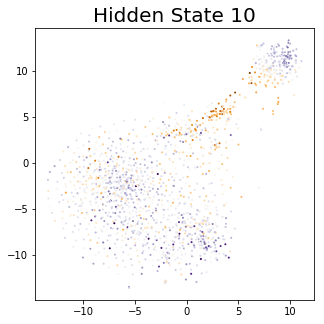

130


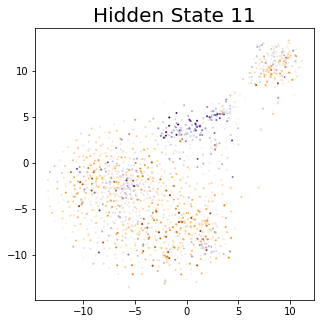

134


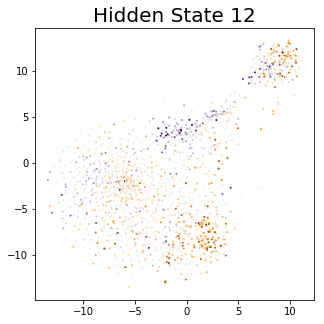

226


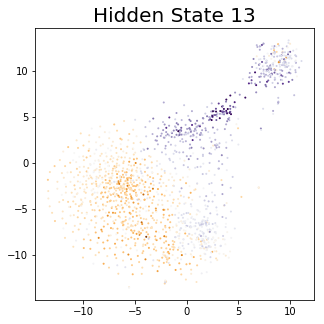

88


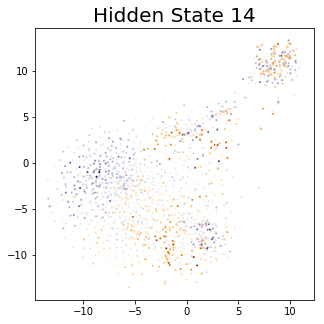

205


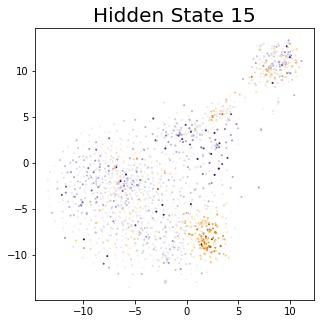

In [73]:
plt.figure()
plt.title("(Log) State Transition Frequency,0 is Root and Leaf")
plt.imshow(np.log(braid.pad_root_transitions(braid.transition_counts).T),cmap='binary')
plt.show()
  
print(braid.state_raw_sample_odds[1])
for hidden_state in range(braid.hidden_states):
    print(np.sum(braid.state_masks[hidden_state]))
    plt.figure(figsize=(5,5))
    plt.title(f"Hidden State {hidden_state}",fontsize=20)
#     plt.scatter(iftc[:,0],iftc[:,1],c=braid.lr_finite(hidden_state),cmap='bwr')
    plt.scatter(iftc[:,0],iftc[:,1],c=braid.state_raw_sample_odds[hidden_state],s=1,cmap='PuOr')
    plt.show()
        


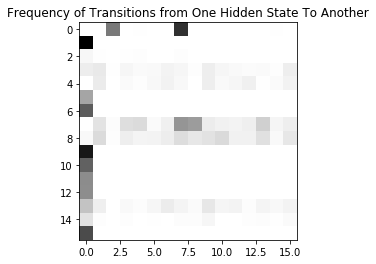

In [74]:
plt.figure()
plt.title("Frequency of Transitions from One Hidden State To Another")
plt.imshow(braid.pad_root_transitions(braid.transition_counts).T,cmap='binary')
plt.show()

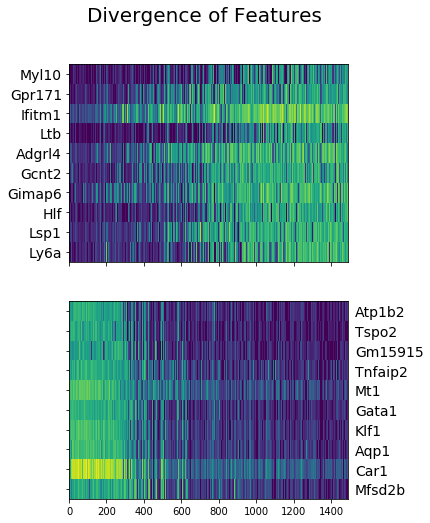

In [75]:
forest.plot_sample_feature_split(braid.lr_finite(7),plot_n=10)

In [76]:
# braid.backup('./forest_vision_braid')
braid.lr_finite(7)

array([0.86603833, 0.78751672, 0.65437489, ..., 0.0458422 , 0.32489811,
       0.07850821])

In [77]:
print(forest.node_feature_summary(braid.hidden_state_to_nodes(7))[:20])
print(forest.node_feature_summary(braid.hidden_state_to_nodes(8))[:20])


[('Atpif1', 11), ('Ybx1', 10), ('Epor', 10), ('Cks2', 9), ('Gm10039', 8), ('Gm8203', 8), ('Hmgb2', 8), ('Hspe1', 7), ('Klf1', 7), ('Lsp1', 6), ('Npm1', 6), ('Ly6a', 6), ('Smim1', 6), ('Atp5g1', 6), ('Dut', 5), ('Car1', 5), ('Gmnn', 5), ('Slc25a5', 5), ('Aqp1', 5), ('Tnfaip2', 5)]
[('Tmem14c', 13), ('Fth1', 8), ('Atpif1', 8), ('Prdx2', 7), ('Car2', 7), ('Fam132a', 6), ('Blvrb', 6), ('Nxpe2', 6), ('Rhag', 5), ('Tmem56', 5), ('Hsp90aa1', 5), ('Rps27l', 4), ('Cldn13', 4), ('Cks2', 4), ('Pla2g12a', 4), ('Hpn', 4), ('Hlf', 4), ('Cpox', 4), ('Hmbs', 4), ('Cox4i1', 4)]


In [78]:
print(forest.node_feature_summary(braid.hidden_state_to_nodes(3))[:20])
print(forest.node_feature_summary(braid.hidden_state_to_nodes(4))[:20])

[('Cd34', 3), ('Tipin', 3), ('Mcm4', 3), ('Pdzk1ip1', 3), ('Nasp', 3), ('Cenpk', 3), ('Mcm2', 2), ('H2afy', 2), ('Tubb5', 2), ('Lig1', 2), ('Cdk6', 2), ('Flt3', 2), ('Blvrb', 2), ('Ran', 2), ('Gm8203', 2), ('Mpl', 2), ('Gmnn', 2), ('Tuba1b', 2), ('Gng11', 2), ('Cdk1', 2)]
[('H2afy', 6), ('Cd53', 6), ('Ctsg', 5), ('Hk3', 4), ('Sell', 4), ('Cst7', 4), ('Plac8', 3), ('BC035044', 3), ('Cd52', 3), ('Tmsb4x', 3), ('Ifitm1', 3), ('Car2', 3), ('Cdk6', 3), ('Flt3', 3), ('Tyrobp', 3), ('Clec12a', 3), ('Mpo', 3), ('Plppr3', 2), ('Sfxn1', 2), ('Ms4a6c', 2)]


In [79]:
print(forest.node_feature_summary(braid.hidden_state_to_nodes(13))[:20])
print(forest.node_feature_summary(braid.hidden_state_to_nodes(14))[:20])

[('Blvrb', 5), ('Mpo', 5), ('Aqp1', 4), ('Cks2', 4), ('Atp1b2', 4), ('Adgrl4', 3), ('Ifi203', 3), ('Mfsd2b', 3), ('Cd53', 3), ('Mt1', 3), ('Flt3', 3), ('Cd52', 3), ('Wfdc17', 3), ('Tyrobp', 2), ('Ighv8-8', 2), ('Ighv14-2', 2), ('Gm15915', 2), ('Hlf', 2), ('Pkm', 2), ('4922502D21Rik', 2)]
[('Cdk1', 3), ('Satb1', 3), ('Cd53', 3), ('Nasp', 2), ('Car2', 2), ('BC035044', 2), ('Mcm3', 2), ('Mon1a', 2), ('Lgals9', 1), ('Mcm5', 1), ('Akr1c19', 1), ('Hn1l', 1), ('Slbp', 1), ('Rcn1', 1), ('Mcm4', 1), ('Apoe', 1), ('Ranbp1', 1), ('Ramp1', 1), ('Trdv4', 1), ('Cbx5', 1)]


In [80]:
print(forest.node_feature_summary(braid.hidden_state_to_nodes(11))[:20])

[('Serpina3g', 3), ('Emb', 3), ('Rmnd5a', 2), ('Cd53', 2), ('Car1', 2), ('Adgrl4', 2), ('Ccl9', 2), ('Mpl', 2), ('Ifitm1', 2), ('Prtn3', 2), ('Atad2', 2), ('Gm15963', 1), ('Spc24', 1), ('Tmsb4x', 1), ('Tuba1b', 1), ('Ppil4', 1), ('AI506816', 1), ('Ncln', 1), ('Eif3g', 1), ('Pecam1', 1)]


In [81]:
print(forest.node_feature_summary(braid.hidden_state_to_nodes(5))[:20])
print(forest.node_feature_summary(braid.hidden_state_to_nodes(6))[:20])

[('Emb', 2), ('Ly6c2', 2), ('Rrm2', 2), ('Prim1', 1), ('H2afy', 1), ('Zcchc24', 1), ('Klhl22', 1), ('Exd2', 1), ('Rab44', 1), ('Epx', 1), ('Hk3', 1), ('Gm42963', 1), ('Ccl9', 1), ('Atp5g1', 1), ('Gm20559', 1), ('Nasp', 1), ('Bub3', 1), ('Sdsl', 1), ('Upp1', 1), ('Myl10', 1)]
[('Mcm5', 3), ('Mcm2', 3), ('Trim47', 2), ('Blvrb', 2), ('Mfsd2b', 2), ('Slc46a3', 2), ('Dhfr', 2), ('Cd82', 2), ('Mpl', 2), ('Prdx2', 2), ('Dut', 2), ('Car2', 2), ('Tipin', 2), ('Hells', 1), ('Cks2', 1), ('Pole', 1), ('Hjurp', 1), ('Cybb', 1), ('Abhd17b', 1), ('Mgst3', 1)]


In [82]:
print(forest.node_feature_summary(braid.hidden_state_to_nodes(1))[:20])
print(forest.node_feature_summary(braid.hidden_state_to_nodes(2))[:20])

[('Plac8', 5), ('Tuba1b', 4), ('Adgrg3', 4), ('BC035044', 3), ('Klf1', 3), ('Ran', 3), ('Aqp1', 2), ('Atp8b4', 2), ('Adgrg1', 2), ('Wfdc17', 2), ('Samd14', 2), ('Ctsg', 2), ('Gm8203', 2), ('Cd52', 2), ('Pdzk1ip1', 2), ('Ramp1', 2), ('Gng11', 2), ('Atp1b2', 2), ('Ckap5', 2), ('Adgrl4', 2)]
[('Procr', 1), ('Hlf', 1), ('Nek9', 1), ('Mfsd8', 1), ('Hbb-bt', 1), ('Mecom', 1), ('Ybx3', 1), ('Trmt2b', 1), ('Trpm5', 1), ('Sh3bgrl', 1), ('Gm4956', 1), ('Cpt1a', 1), ('Oasl2', 1), ('Elane', 1), ('Ccng2', 1), ('Atpif1', 1), ('Pglyrp2', 1), ('Tk1', 1), ('Camp', 1), ('March6', 1)]


In [83]:
for f in forest.node_feature_summary(braid.hidden_state_to_nodes(9)):
    print(f[0])

Adgrg3
Rnf13
Ctsg
Cd52
Clec12a
Uqcr11
Gm10039
Ly6a
Tyrobp
Pbk
Prtn3
Satb1
Cd34
Serpinf1
Klf1
Apoe
Slc25a21
Ran
Uhrf1
Tmem173
Tmem97
Bpifb5
Ctla2a
Tuba1b
Emb
P4hb
Tspo2
Tgm5
Gpr173
Stat3
Usp11
Mad2l1
Tmem125
Paqr8
Hbp1
Ifitm6
Stom
Rad51ap1
Epx
Def8
Clip3
Ddx58
BC002059
Gm42993
Prps1
Gm12346
Ptprs
Wdr75
Gbp9
Ccl3
Cracr2b
Milr1
Kmo
Zfp60
Alpl
Tnip3
Slc43a3
Galnt6
St8sia4
Zfp874b
Gfi1b
Smim5
Gm15915
Trpm6
Cxcl12
Cd27
Rasal3
Npm1
AA474408
G2e3
Tex38
Nxph1
Ighm
Gm13461
Rasl12
Ctr9
Irf7
Casp2
Cd53
Pgbd1
Hus1b
Tnfrsf1b
Calr
Gpx3
Clcn4
E2f4
Atad2
Amica1
Hlf
Nat8f4
Ptp4a3
Tk1
Odc1
Xaf1
Fkbp1a
Myh10
F5
Rpl39l
2810417H13Rik
Ighv1-81
Ccl9
Dennd6b
Efhc1
Erp29
Sh2d5
Atp5b
Eif4ebp1
Trpv4
Tmsb4x
Snai3
Zfp715
Ect2
Mfsd2b
D930020B18Rik
1810011H11Rik
Eml4
Mtap
Rasip1
S100a10
C1qbp
1200007C13Rik
Fam20a
Nt5c3
Ncl
Myc
Plac8
Smpd4
Hk3
Sgpp1
Ppt1
Wfdc17
Rsbn1l
2610035D17Rik
Bub1b
Trim44
Baiap3
Mut
Tmem176a
Akna
Dtl
Minpp1
Fam46a
Slc38a5
Egr2
Skiv2l2
Tespa1
Gmnn
Cdca3
Gimap5
Serpina3g
Ctse
Dock10
Wdsub1
Adsl
Gd

In [84]:
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()

from goatools.base import download_ncbi_associations
gene2go = download_ncbi_associations()


from goatools.obo_parser import GODag

obodag = GODag("go-basic.obo")

from goatools.associations import read_ncbi_gene2go,dnld_assc

geneid2gos_mouse = read_ncbi_gene2go("gene2go", taxids=[10090])

print("{N:,} annotated mouse genes".format(N=len(geneid2gos_mouse)))

from goatools.go_enrichment import GOEnrichmentStudy
from goatools.test_data.genes_NCBI_10090_ProteinCoding import GENEID2NT as GeneID2nt_mus



  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2019-02-28) 47,399 GO Terms
  20,121 items READ: gene2go
20,121 annotated mouse genes


In [85]:
goeaobj = GOEnrichmentStudy(
        GeneID2nt_mus.keys(), # List of mouse protein-coding genes
        geneid2gos_mouse, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

fisher module not installed.  Falling back on scipy.stats.fisher_exact
 67% 19,010 of 28,212 population items found in association


In [86]:
symbol2id = {v[5]:k for k,v in GeneID2nt_mus.items()}

def try_symbol(symbols):
    ids = []
    for symbol in symbols:
        if symbol in symbol2id:
            ids.append(symbol2id[symbol])
    return ids

In [87]:
gores = goeaobj.run_study(try_symbol([x[0] for x in forest.node_feature_summary(braid.hidden_state_to_nodes(10))]))

gores_filtered = sorted([r for r in gores if r.p_fdr_bh < 0.05],key=lambda r: r.p_fdr_bh)

gores_filtered = [g for g in gores_filtered if g.goterm.namespace == 'biological_process' or g.goterm.namespace == 'molecular_function']

print(gores_filtered)

 99%    139 of    141 study items found in association
100%    141 of    141 study items found in population(28212)
Calculating 18,000 uncorrected p-values using fisher_scipy_stats
  18,000 GO terms are associated with 19,010 of 28,212 population items
   1,517 GO terms are associated with    139 of    141 study items
       5 GO terms found significant (< 0.05=alpha) after multitest correction: statsmodels fdr_bh
[GOEnrichmentRecord(GO:0048821), GOEnrichmentRecord(GO:0016787)]


In [88]:
# gores_filtered[1].__dict__

In [89]:
[go.name for go in gores_filtered]

['erythrocyte development', 'hydrolase activity']

In [90]:
for term in [go.name for go in gores_filtered]:
    print(term)

erythrocyte development
hydrolase activity


In [91]:
def hidden_state_sample_cluster_matrix(forest,braid):
    state_cluster_matrix = np.zeros((len(forest.sample_clusters),braid.hidden_states))
    for i,sample_cluster in enumerate(forest.sample_clusters):
        for j,hidden_state in enumerate(braid.state_sample_log_odds):
            odds_sample_x_cluster = hidden_state[sample_cluster.samples]
            state_cluster_matrix[i,j] = np.mean(odds_sample_x_cluster)
    return state_cluster_matrix

In [92]:
clusters_x_hs = hidden_state_sample_cluster_matrix(forest,braid)

cluster_sort = np.array(dendrogram(linkage(clusters_x_hs,method='average'),no_plot=True)['leaves'])
hs_sort = np.array(dendrogram(linkage(clusters_x_hs.T,method='average'),no_plot=True)['leaves'])

cell_cluster_mask = np.array([len(c.samples) > 40 for c in forest.sample_clusters])
cell_cluster_mask = cell_cluster_mask[cluster_sort]

hidden_state_mask = np.array([np.sum(hsm) > 100 for hsm in braid.state_masks[:,braid.live_mask]])
print(hidden_state_mask)
hidden_state_mask = hidden_state_mask[hs_sort]

[False  True False  True  True  True  True  True  True  True  True  True
  True  True False  True]


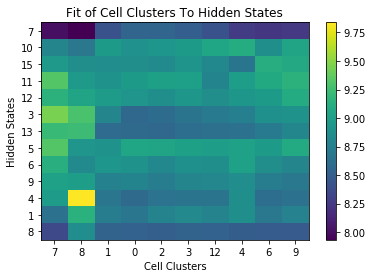

In [93]:
plt.figure()
plt.title("Fit of Cell Clusters To Hidden States")
plt.imshow(clusters_x_hs[cluster_sort][cell_cluster_mask].T[hs_sort][hidden_state_mask],aspect='auto')
plt.ylabel("Hidden States")
plt.xlabel("Cell Clusters")
plt.xticks(np.arange(len(cluster_sort[cell_cluster_mask])),cluster_sort[cell_cluster_mask])
plt.yticks(np.arange(len(hs_sort[hidden_state_mask])),hs_sort[hidden_state_mask])
plt.colorbar()
plt.show()